### TSMC2330 Stock Price Up/Down Estimation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta import add_all_ta_features
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### 繪製模型訓練準確率直條圖 function

In [3]:
def performanceChart(report:dict):
    import matplotlib.pyplot as plt
    import numpy as np

    # 1. 先設定 matplotlib 的中文字型（以 Windows 微軟正黑體為例）
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或 'SimHei'，視你系統字型而定
    plt.rcParams['axes.unicode_minus'] = False  # 讓負號正常顯示

    # 2. 在設定 seaborn 風格時，再指定字型（必須在 import seaborn 後執行）
    sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei', 'Arial']})

    labels = ['precision', 'recall', 'f1-score']
    class0 = [round(report['0']['precision'],2), round(report['0']['recall'],2), round(report['0']['f1-score'],2)]
    class1 = [round(report['1']['precision'],2), round(report['1']['recall'],2), round(report['1']['f1-score'],2)]
    support = [round(report['0']['support'],2), round(report['1']['support'],2)]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8,4))

    # 第一張：分數指標
    import matplotlib.pyplot as plt
    import numpy as np

    labels = ['precision', 'recall', 'f1-score']
    class0 = [round(report['0']['precision'],2), round(report['0']['recall'],2), round(report['0']['f1-score'],2)]
    class1 = [round(report['1']['precision'],2), round(report['1']['recall'],2), round(report['1']['f1-score'],2)]
    support = [round(report['0']['support'],2), round(report['1']['support'],2)]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, class0, width, label='跌(0)', color='#1985DD')
    bars2 = ax.bar(x + width/2, class1, width, label='漲(1)', color='#FF8C00')
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')


# 調整圖例位置，往左移至第一個長條上方附近
    ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.0), labelspacing=0.2)

    ax.set_ylabel('分數')
    ax.set_title('precision/recall/f1-score')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    plt.show()


    # 第二張：support
    plt.subplot(1,2,2)
    plt.bar(['跌 (0)', '漲 (1)'], support, color=['#1985DD', '#EE9536'])
    plt.ylabel('數量')
    plt.title('support')
    for i, v in enumerate(support):
        plt.text(i, v+3, str(v), ha='center')

    plt.tight_layout()
    plt.show()


### 由 Yahoo Finance 下載台股 2330.TW 資料

In [4]:
import yfinance as yf
# 下載台積電股價資料
data = yf.download(
    ["2330.TW"],
    start="2020-01-01",
    end="2025-06-03",
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    prepost=False,
    threads=True,
)

# 將資料寫入 CSV 檔案
data.to_csv("tsmc2330.csv", encoding="utf-8-sig")

[*********************100%***********************]  1 of 1 completed


In [5]:
# header=1 表示跳過第一列（原本的header），直接把第二列當作欄位名稱
df = pd.read_csv('tsmc2330.csv', header=1)

# 刪除第一列（原資料的第一列，現在是索引0）
df = df.drop(0).reset_index(drop=True)
df.rename(columns={'A1': 'Date'}, inplace=True)

#print("原本欄位名稱：", df.columns.tolist())

# 修改第一欄的欄位名稱
cols = df.columns.tolist()
cols[0] = 'Date'  # 改成你想要的新名稱
df.columns = cols

# 確認修改後欄位名稱
#print("修改後欄位名稱：", df.columns.tolist())

# 儲存結果
df.to_csv('tsmc2330.csv', index=False)

#### 特徵工程：加入技術指標 (MA5, MA10, MA20, RSI, BB band_upper, BB band_lower.), 
#### 將Return欄 漲、跌欄位標準化改為 0(跌、平盤), 1(漲)，並放在最後一欄 Target 做為目標值

In [6]:
import pandas as pd
import numpy as np

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(price, slow=26, fast=12, signal=9):
    ema_fast = price.ewm(span=fast).mean()
    ema_slow = price.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    return macd, signal_line

def compute_bollinger_bands(price, window=20, num_std=2):
    ma = price.rolling(window=window).mean()
    std = price.rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    return upper_band, lower_band


# 1. 讀取資料
df = pd.read_csv("tsmc2330.csv")

# 2. 新增技術指標
df["Return"] = df["Close"].pct_change()*100
df["MA5"] = df["Close"].rolling(window=5).mean()
df["MA10"] = df["Close"].rolling(window=10).mean()
df["MA20"] = df["Close"].rolling(window=20).mean()
df["Price_Change"] = df["Close"] - df["Open"]

# RSI
df["RSI"] = compute_rsi(df["Close"])

# MACD & Signal Line
df["MACD"], df["MACD_Signal"] = compute_macd(df["Close"])

# Bollinger Bands
df["BB_Upper"], df["BB_Lower"] = compute_bollinger_bands(df["Close"])

# 3. 處理漲跌目標欄位
#df["Increase"] = df["Increase"].str.replace("%", "").astype(float)
#標準化 "return" 成為Target 欄位: -1 (跌) 0 (漲), 1 (漲)
df["Target"] = df['Return'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 0))

# 移除缺失值
df.dropna(inplace=True)
#df.head()


df.to_csv('tsmc2330-1.csv', index = False)

### 讀取資料

In [7]:
# 🔹 讀取資料
df = pd.read_csv("tsmc2330-1.csv")
#df["Date"] = pd.to_datetime(df["Date"])
#df = df.sort_values("Date")
df.head()


,Date,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
0,2020-02-07,296.974805,297.424766,293.375110,295.174957,28798327.0,-1.353392,293.015186,293.825137,298.729733,-1.799847,43.065611,-1.502280,-1.425555,313.739860,283.719607,0
1,2020-02-10,289.325524,295.175029,288.875562,294.725067,30632424.0,-0.152415,295.264996,293.195187,298.212277,5.399543,41.044782,-1.414516,-1.423327,313.013582,283.410972,0
2,2020-02-11,297.424844,299.224692,296.974882,298.324768,27524935.0,1.221376,296.434900,293.060202,297.852309,0.899924,42.753562,-1.088260,-1.355815,312.249540,283.455077,1
3,2020-02-12,300.124602,302.374411,299.674640,301.474487,37612639.0,1.055802,297.784784,293.240189,297.987296,1.349886,41.911722,-0.608345,-1.205433,312.471306,283.503285,1
4,2020-02-13,304.174259,304.174259,301.474487,301.474487,22757021.0,0.000000,298.234753,294.905042,298.234773,-2.699772,45.967721,-0.228426,-1.009105,312.782576,283.686970,0


In [8]:
features = df.drop(columns=["Date", "Target"])  # 特徵值不包含 日期 及 Target 欄位
X = features
y = df["Target"]  #設定目標值在 Target 欄位

In [7]:
df.describe()

,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
count,1292.000000,1292.000000,1292.000000,1292.000000,1.292000e+03,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000
mean,595.360967,599.821529,590.479683,595.078570,3.642305e+07,0.106580,594.057826,592.743625,590.140061,-0.282397,53.459131,3.493344,3.439495,626.286752,553.993369,0.486068
std,216.674626,218.742178,214.848820,216.692079,2.091602e+07,1.890412,216.279444,215.802766,214.745578,7.113594,16.736469,12.772336,12.013573,229.646059,201.531273,0.499999
min,228.982575,229.891236,213.989668,225.347931,0.000000e+00,-9.978772,235.510965,241.787712,247.599425,-36.672738,6.666643,-47.632487,-39.760063,265.994287,217.831624,0.000000
25%,471.836585,475.528531,468.251515,471.513390,2.250091e+07,-0.930228,470.900143,470.113753,464.769073,-3.785395,41.153700,-3.126037,-2.959771,498.907506,437.790709,0.000000
50%,546.292876,550.333838,542.200843,546.882965,3.194742e+07,0.000000,546.963361,547.416077,548.079541,0.000000,52.683462,2.592993,2.627340,570.763016,519.938956,0.000000
75%,622.326418,626.608386,615.602026,622.551666,4.325209e+07,1.104984,623.063486,617.321535,609.599728,2.891347,65.541997,10.265712,10.055555,645.567600,573.381481,1.000000
max,1139.828227,1149.739776,1124.960938,1124.960938,1.663077e+08,9.974080,1110.093628,1101.668799,1096.217438,40.826760,100.000000,44.108970,39.827124,1136.998153,1057.548329,1.000000


#### 上面的變數 features 存放各個特徵變數的資料。
除了 "Date","Target" 2 個欄位外，其餘欄位做 RobustScalor 標準化並寫入 tsmc2330-2_Robust.csv，"Date","Target" 2欄原始資料請一併寫入至原來的欄位位置。

In [9]:
from sklearn.preprocessing import RobustScaler

# 需要標準化的欄位
feature_cols = [col for col in df.columns if col not in ["Date", "Target"]]

# RobustScaler 標準化
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# 寫入 CSV
df_scaled.to_csv("tsmc2330-2_Robust.csv", index=False)

#### prompt: 請使用 Prof. J.W.Tukey 在1977年於Exploratory data analysis 所發表的方式計算 tsmc2330-2_Robust.csv 各欄的盒鬚圖及長條圖的常態分佈圖、Q-Q plot. ("Date", "Target" 2欄不用畫圖)

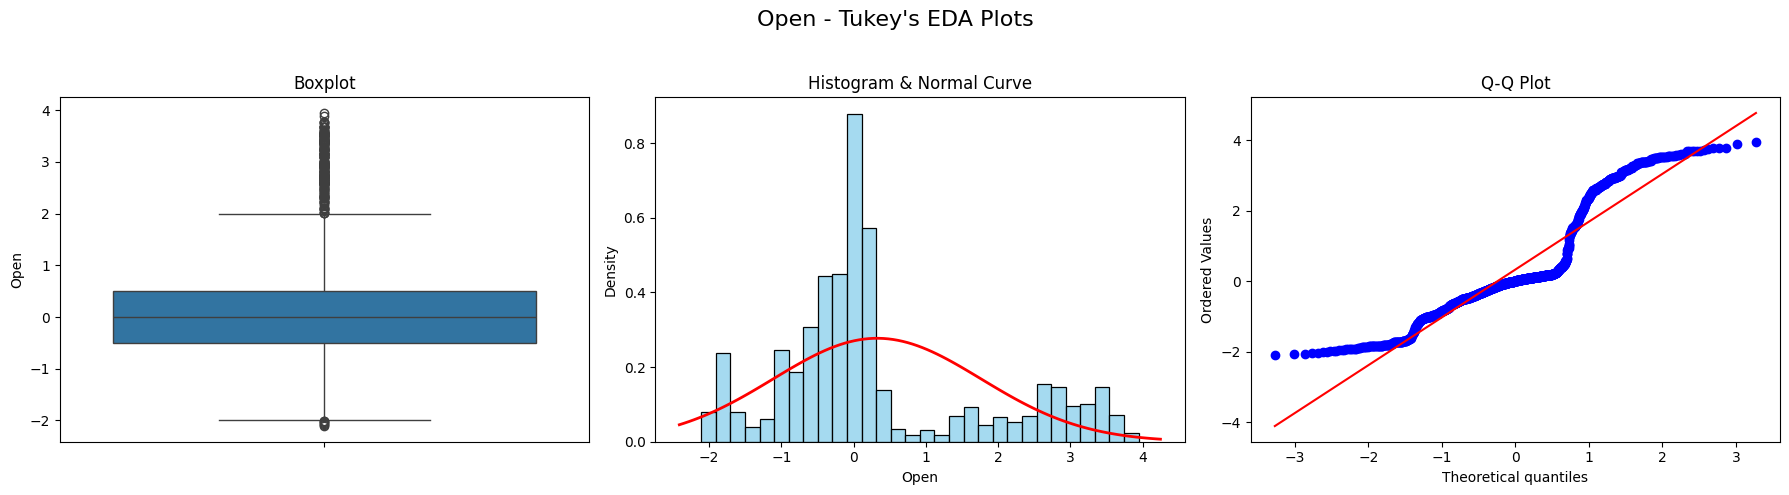

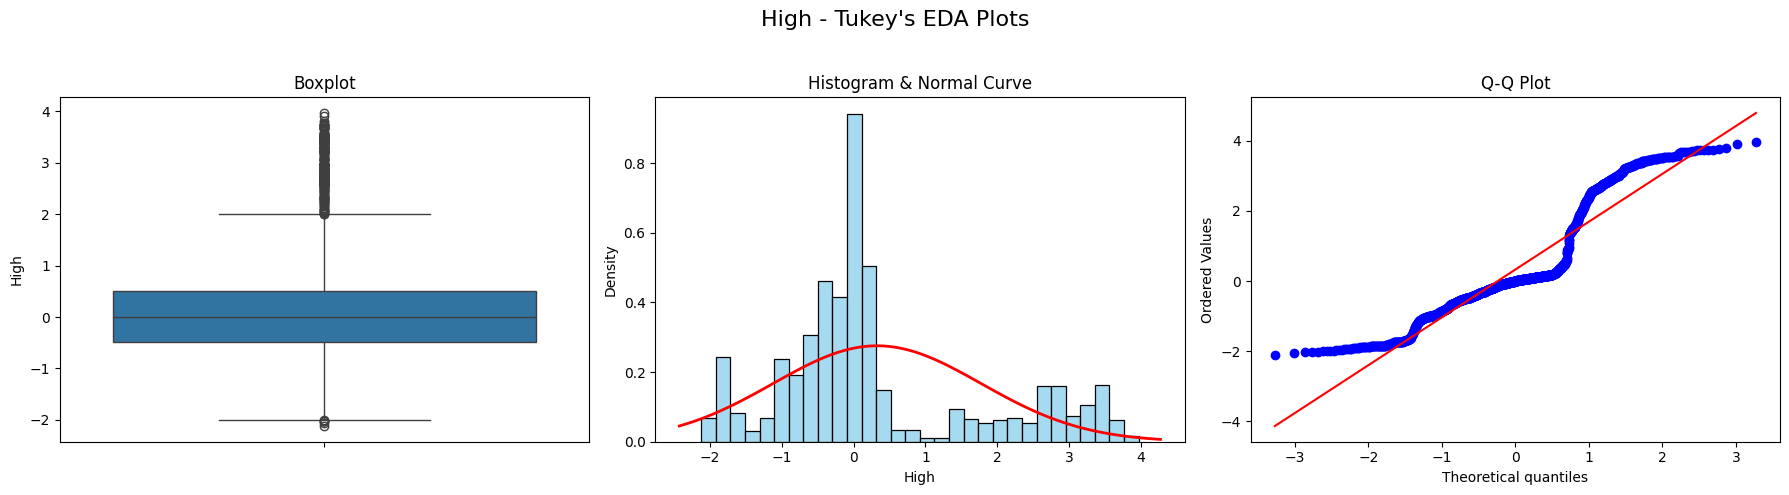

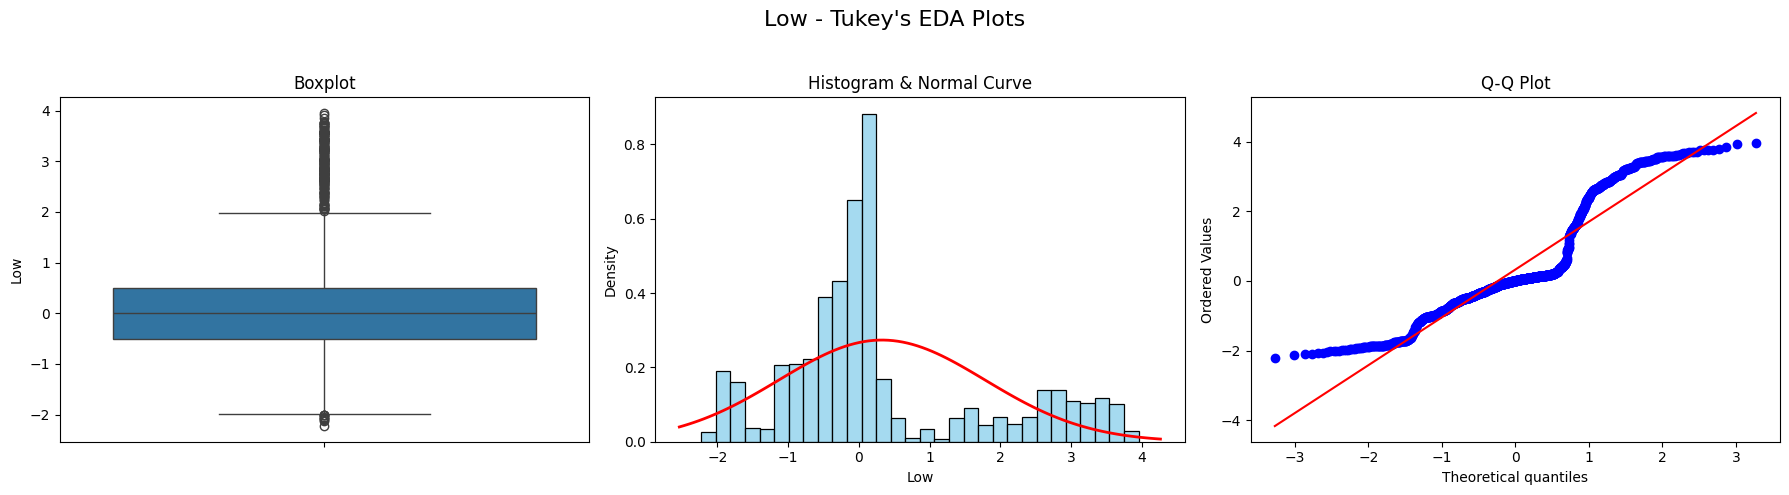

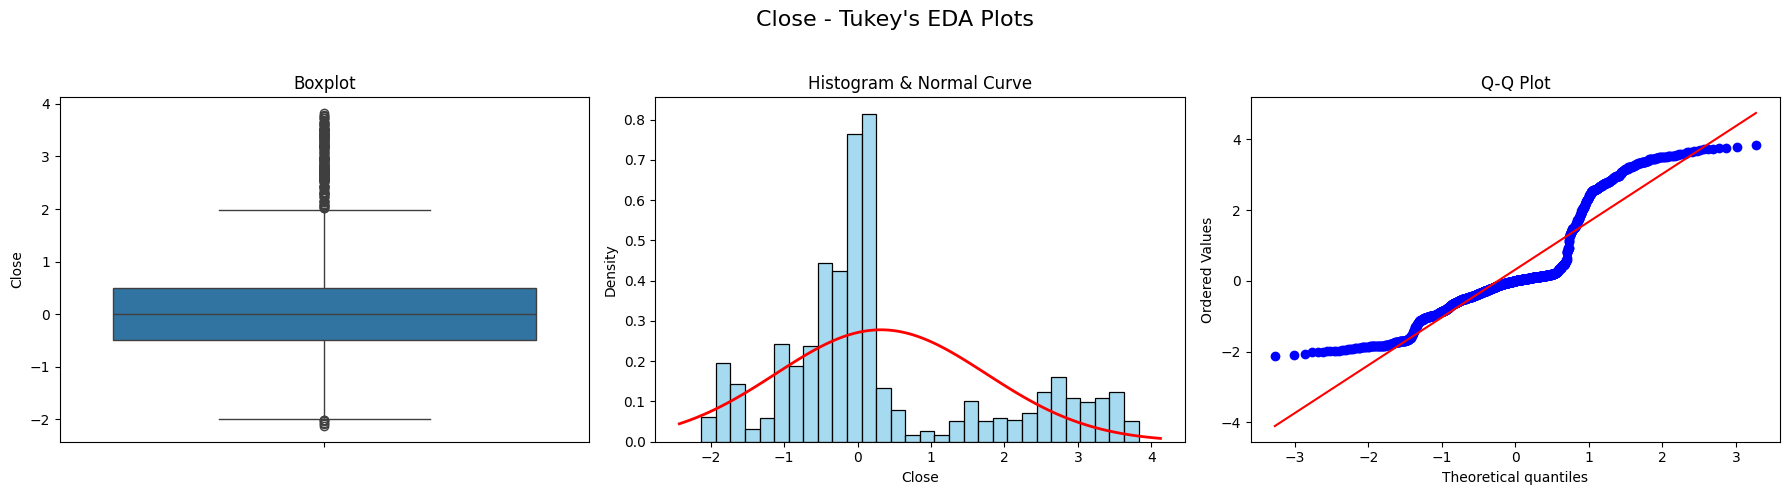

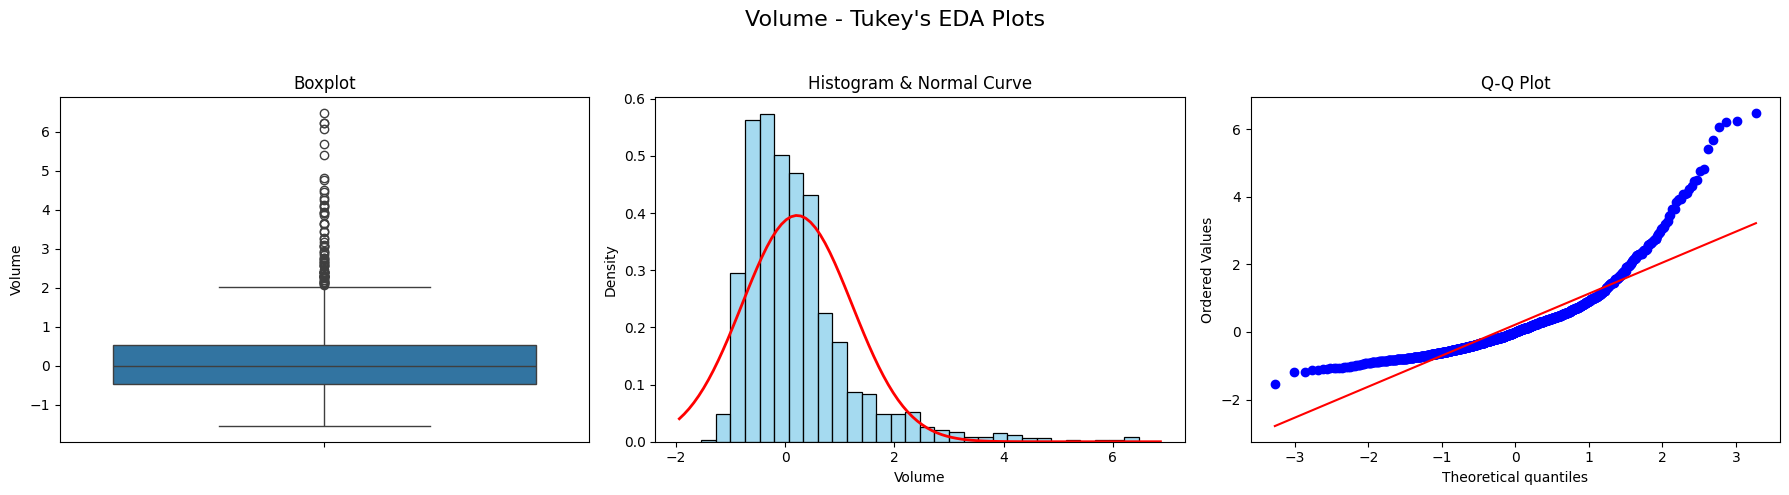

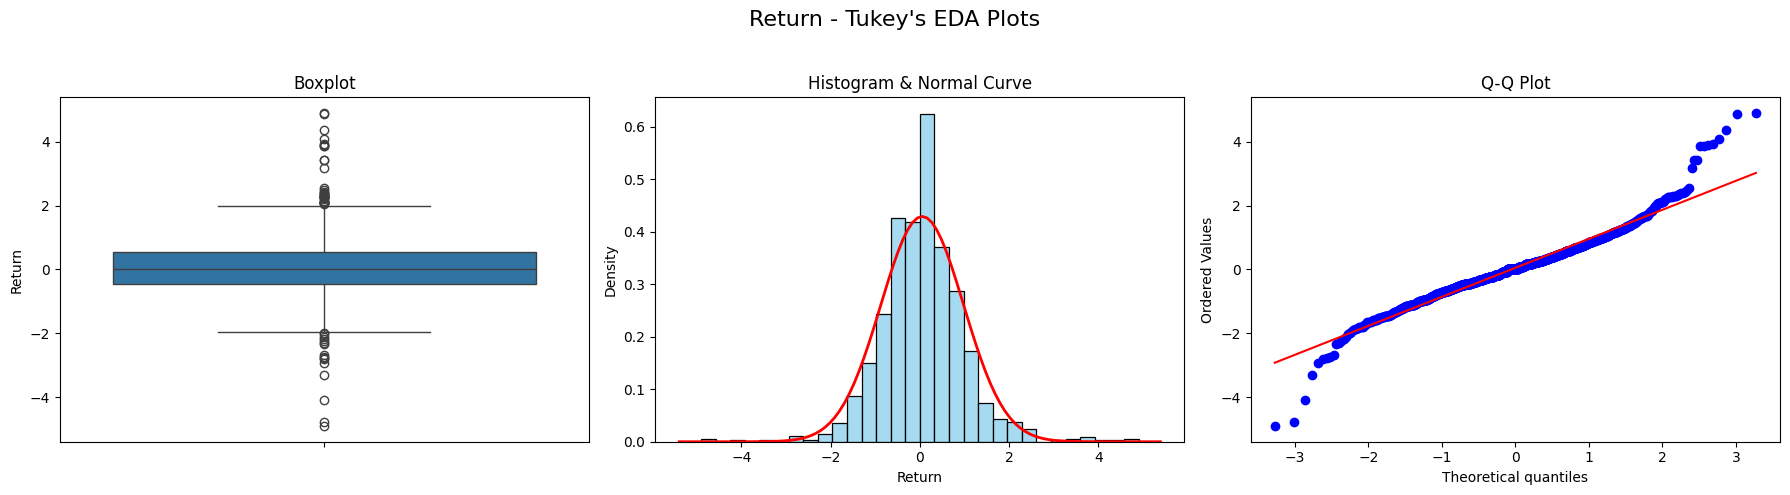

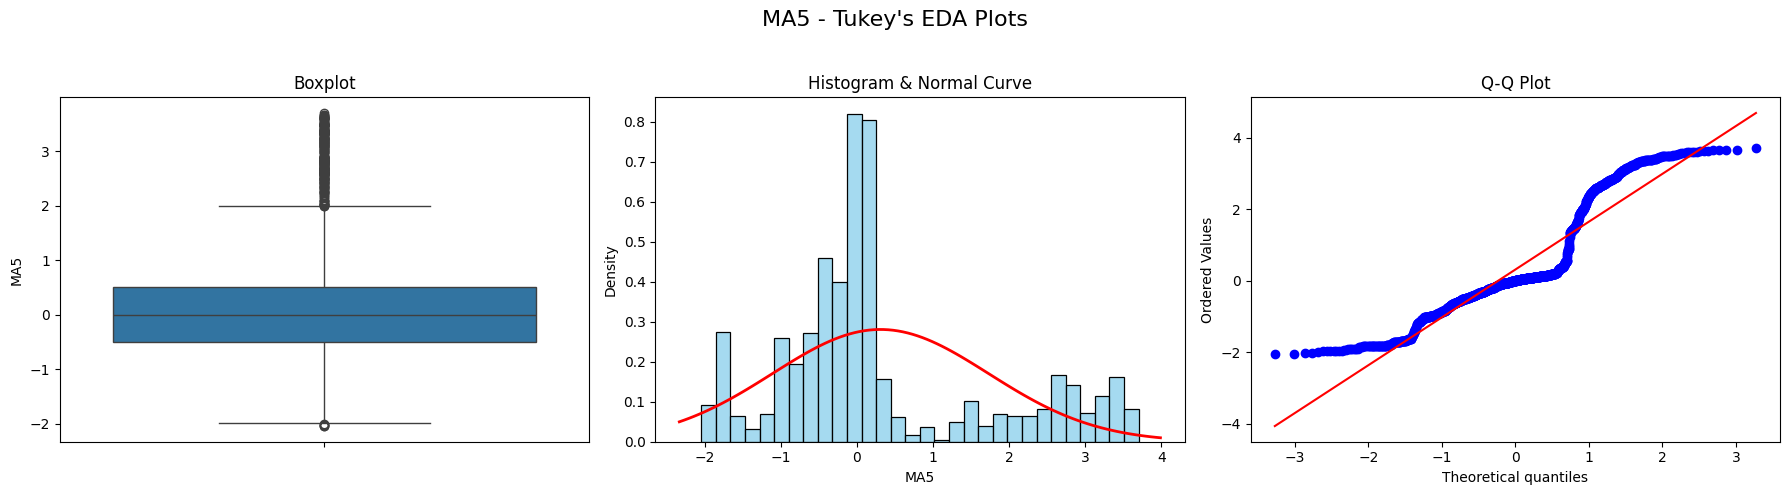

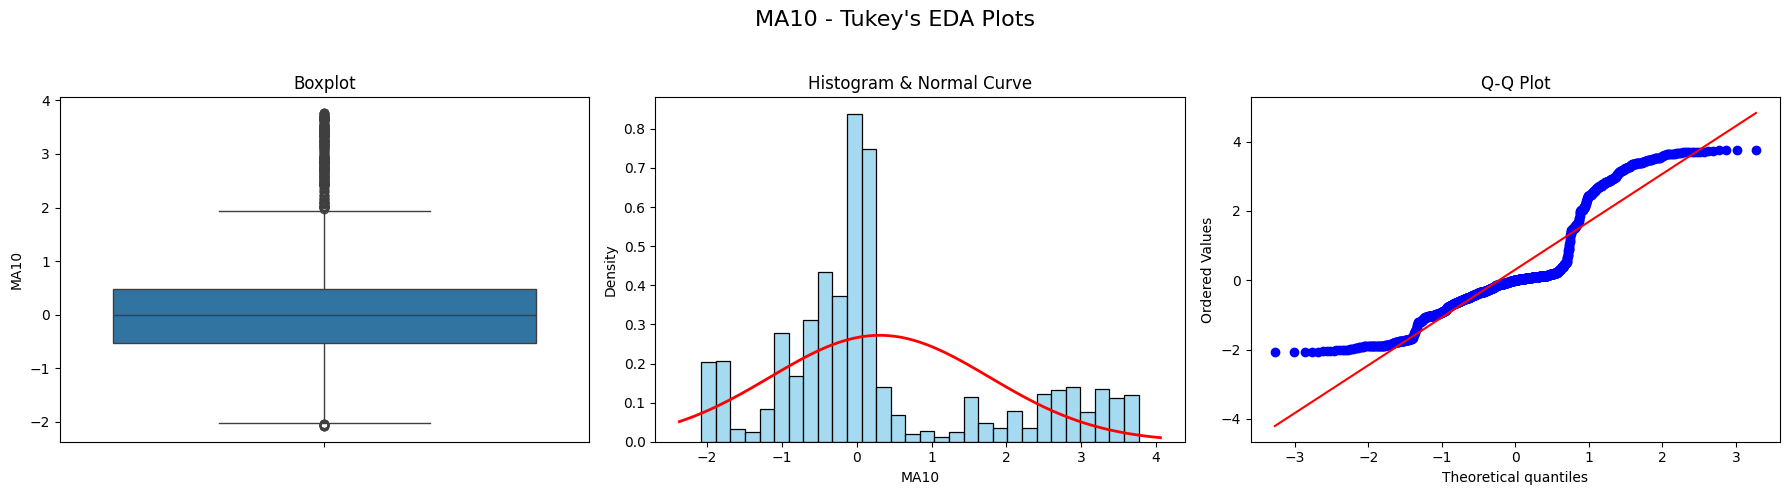

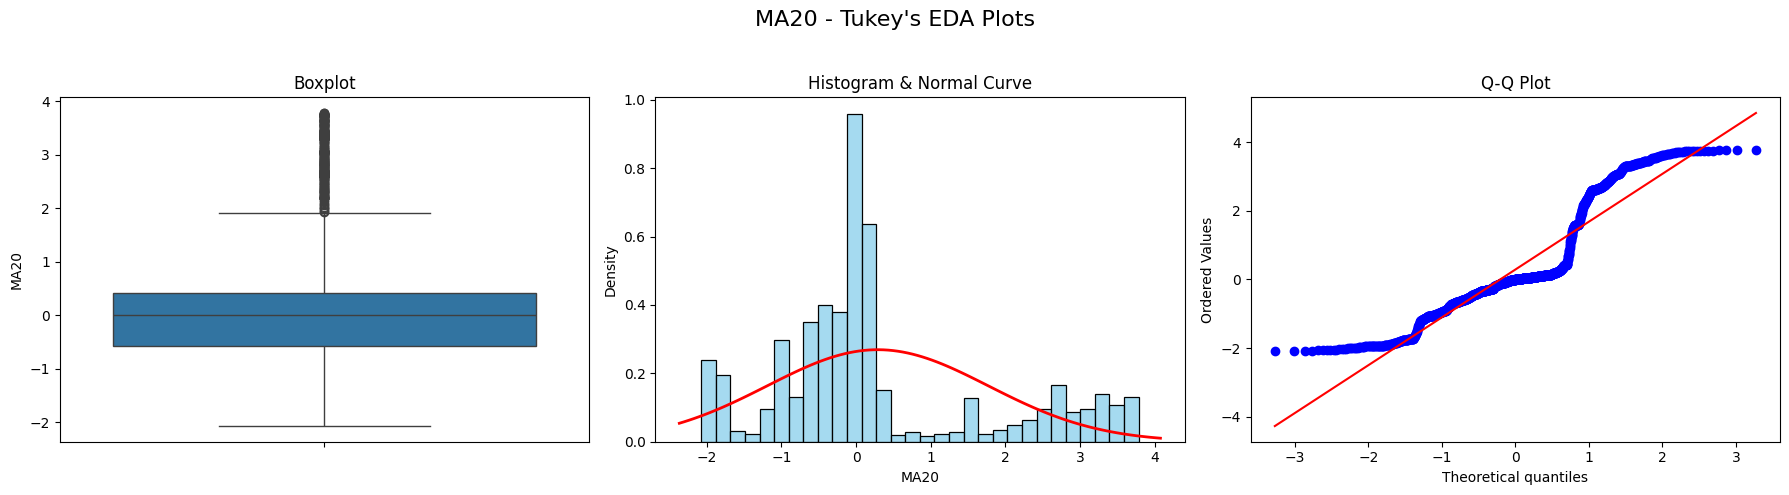

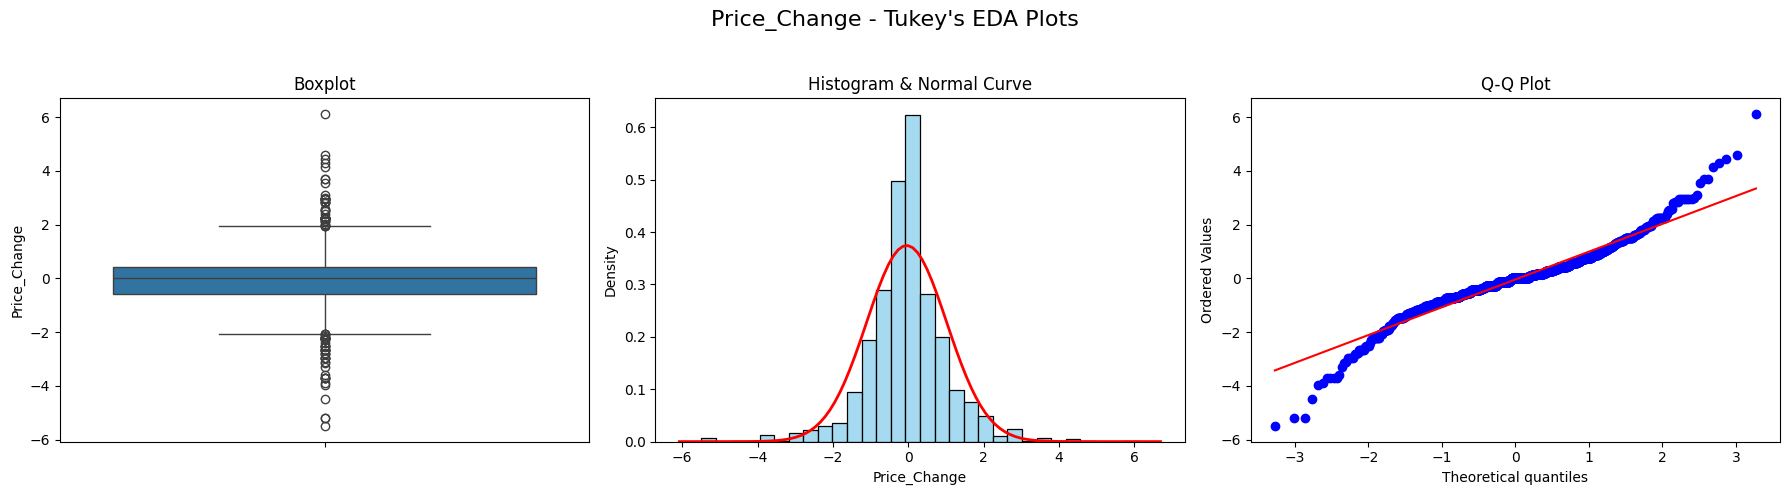

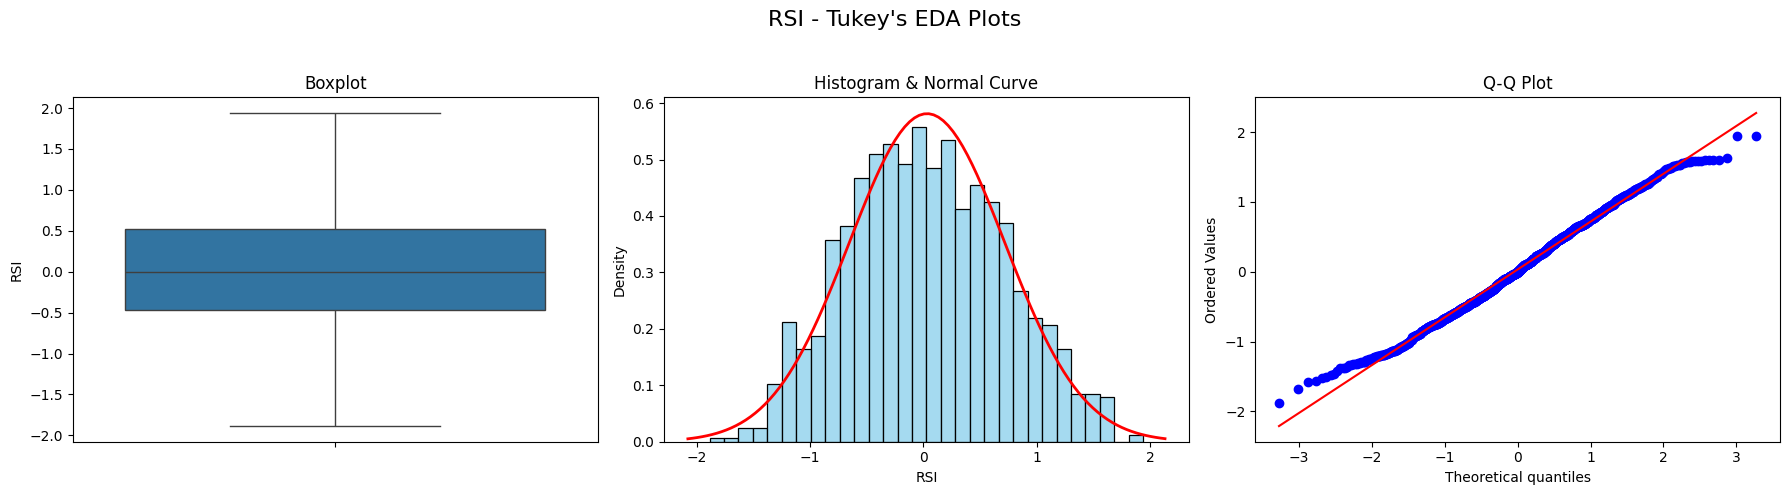

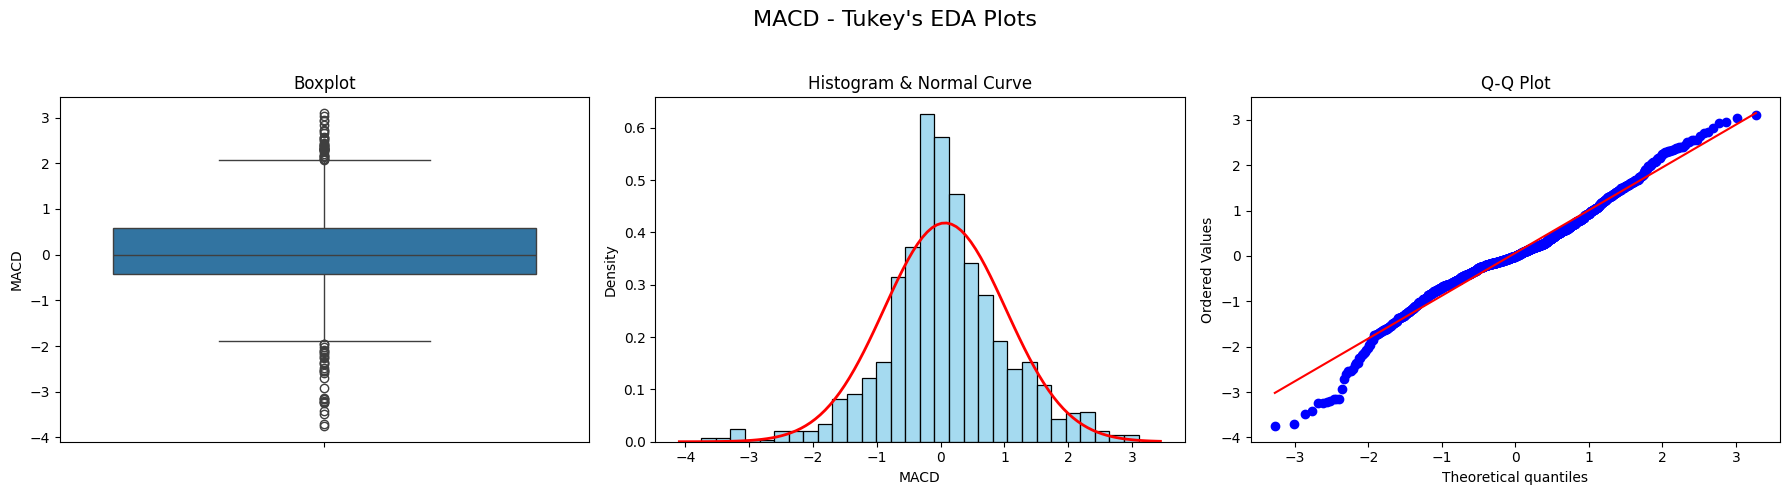

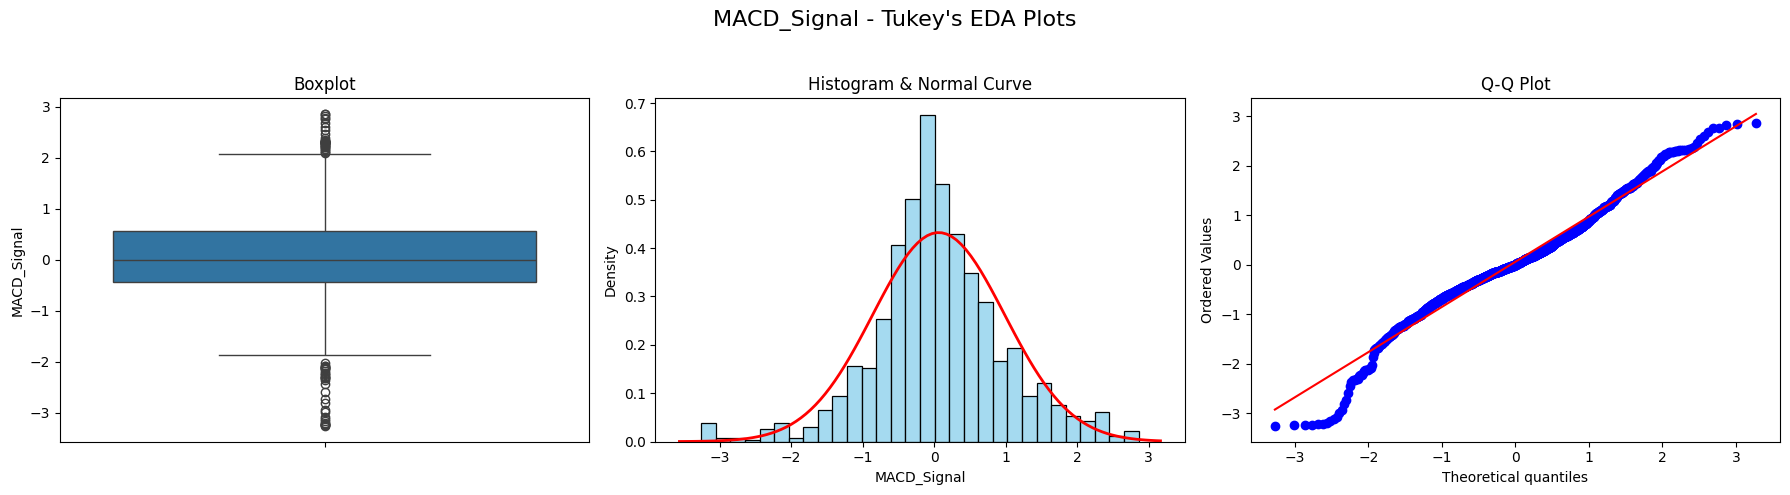

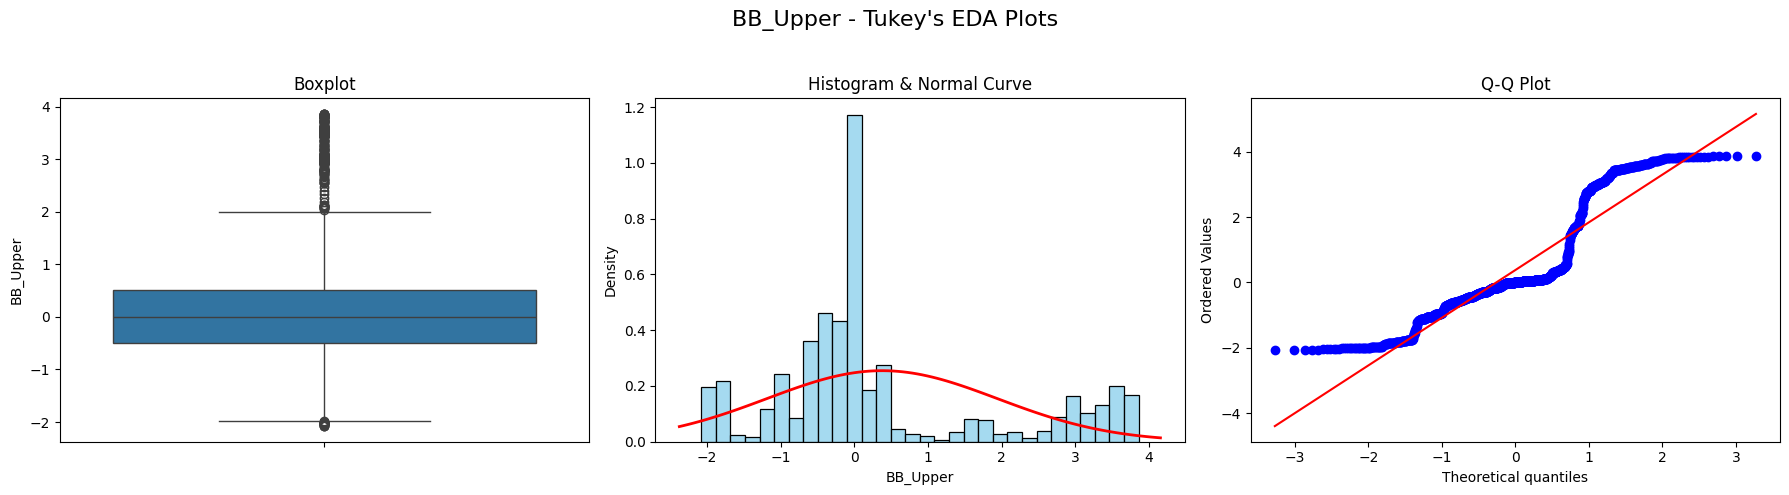

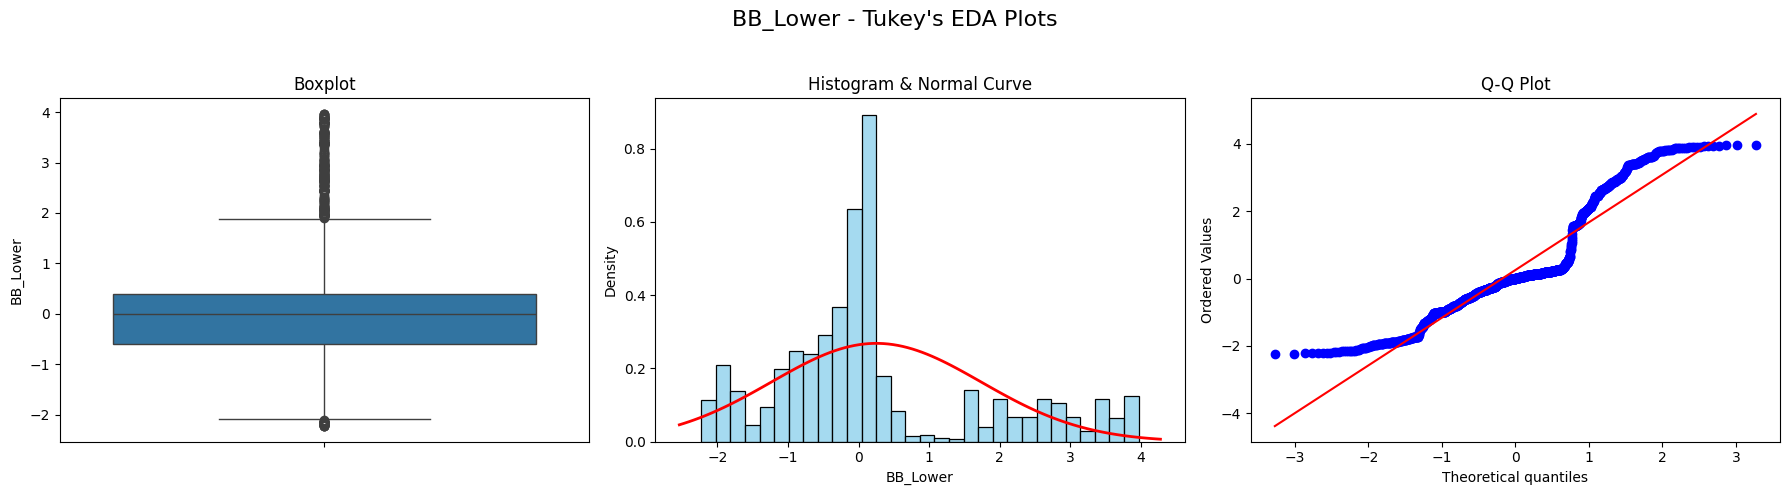

In [10]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df_robust = pd.read_csv("tsmc2330-2_Robust.csv")

# 需要繪圖的欄位
plot_cols = [col for col in df_robust.columns if col not in ["Date", "Target"]]

for col in plot_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{col} - Tukey's EDA Plots", fontsize=16)
    
    # 盒鬚圖 (Boxplot)
    sns.boxplot(y=df_robust[col], ax=axes[0])
    axes[0].set_title("Boxplot")
    
    # 長條圖及常態分佈圖 (Histogram + Normal Curve)
    sns.histplot(df_robust[col], kde=False, stat="density", ax=axes[1], bins=30, color='skyblue')
    # 正態分佈曲線
    mu, std = df_robust[col].mean(), df_robust[col].std()
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[1].plot(x, p, 'r', linewidth=2)
    axes[1].set_title("Histogram & Normal Curve")
    
    # Q-Q plot
    stats.probplot(df_robust[col], dist="norm", plot=axes[2])
    axes[2].set_title("Q-Q Plot")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### 特徵選擇
#### 使用Pearson's correlation coefficient 計算

### tsmc2330-2_Robust.csv 熱力圖

In [11]:
#  選擇特徵變數分析
features_analysis = df_robust.drop(columns=["Date"])


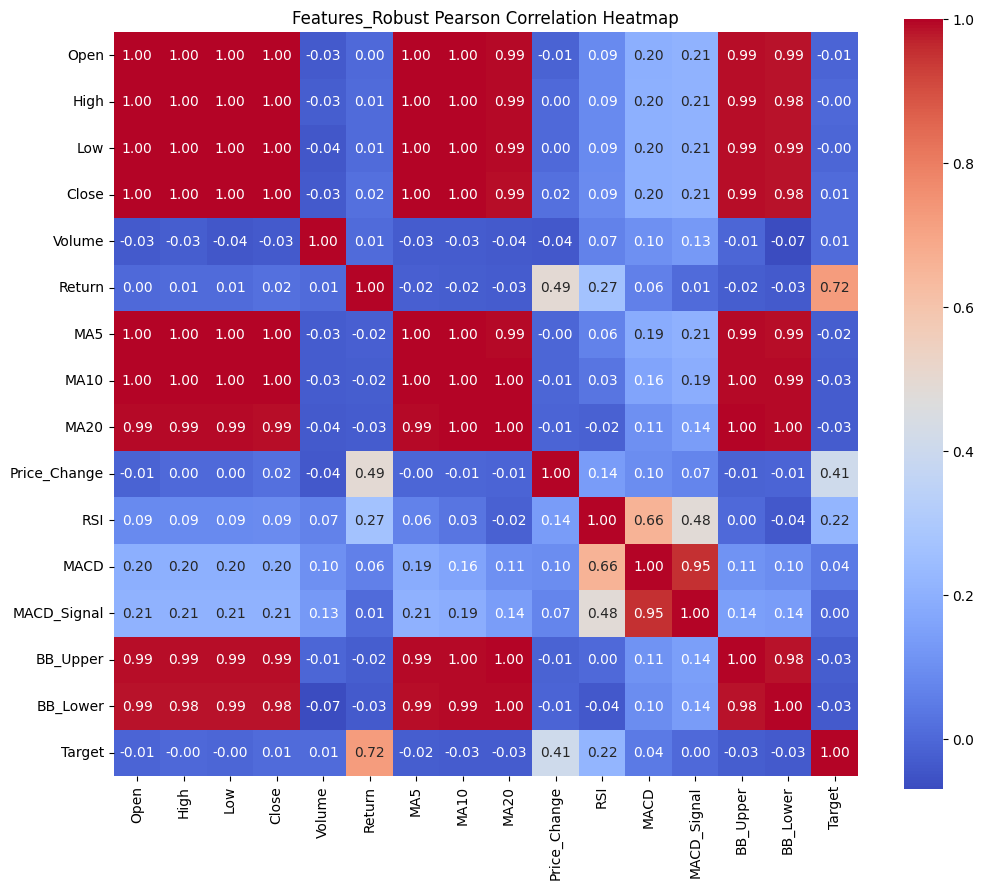

In [12]:
# 計算 Pearson's correlation coefficient
# features_robust =df_robust.drop(columns=["Column1", "Date"]) 上面已經有設定 feature_robust
corr_matrix = features_analysis.corr(method='pearson')

# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Features_Robust Pearson Correlation Heatmap")
plt.show()

### 由熱力圖分析 Pearson's corelation coefficient, 最相關的特徵，其相關係數如下:
- Return: 0.72
- Price change: 0.42
- RSI: 0.23

### 使用 Spearman 相關係數分析特徵變數相關性

In [13]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df_robust = pd.read_csv("tsmc2330-2_Robust.csv")

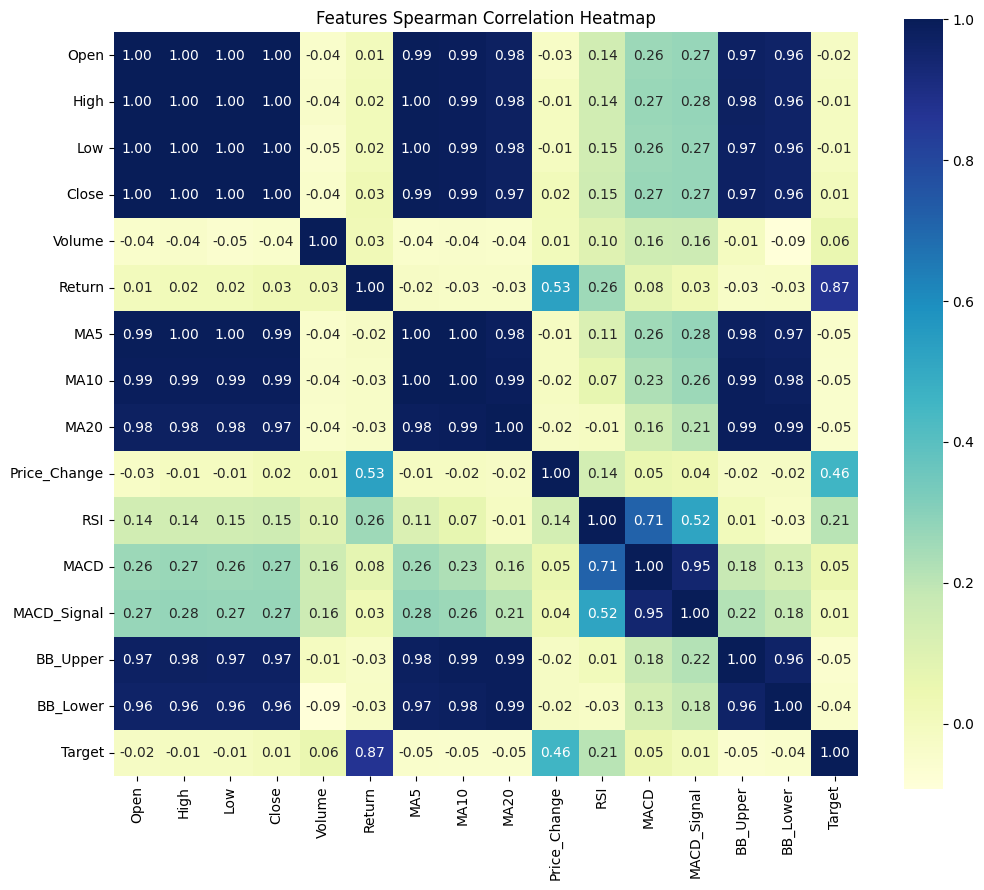

In [14]:
# Spearman 相關係數分析
#features_analysis = df_robust.drop(columns=["Date"])  使用上面的設定
corr_matrix_spearman = features_analysis.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_spearman, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Features Spearman Correlation Heatmap")
plt.show()

相關性高的特徵變數及其相關係數:
- Return: 0.89
- Price_Change: 0.47
- RSI: 0.22

In [15]:
# 📊 分割訓練與測試資料
features = df_robust.drop(columns=["Date", "Target"]) 
X = features
y = df_robust["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)


📘 回歸樹準確率： 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       192
           1       1.00      1.00      1.00       196

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



<Figure size 800x400 with 0 Axes>

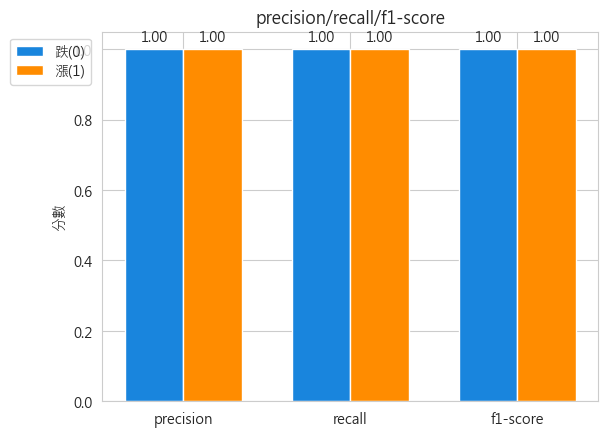

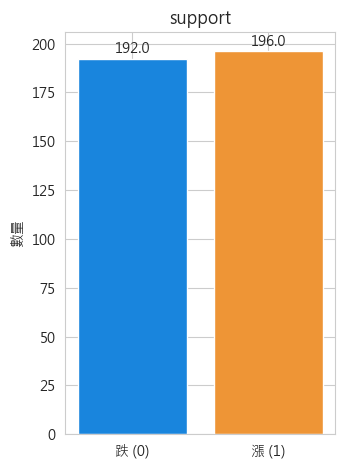

In [16]:
#  回歸樹模型
tree_model = DecisionTreeClassifier(max_depth=5, random_state=0)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

print("📘 回歸樹準確率：", accuracy_score(y_test, tree_pred))
print(classification_report(y_test, tree_pred))
report = classification_report(y_test,tree_pred,output_dict= True)
performanceChart(report)

📗 隨機森林準確率： 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       192
           1       1.00      1.00      1.00       196

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



<Figure size 800x400 with 0 Axes>

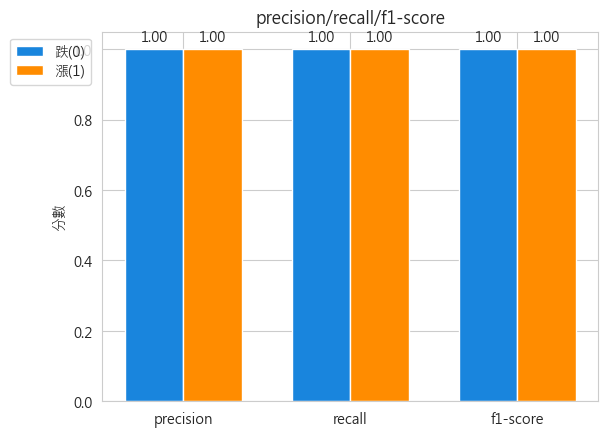

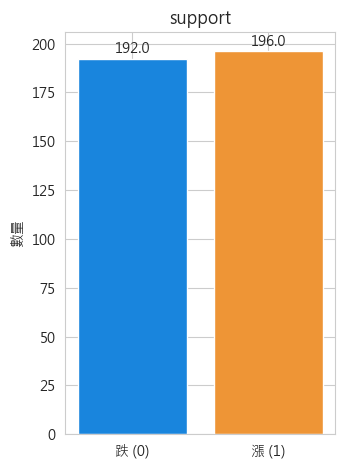

In [17]:
# 🌲 隨機森林模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("📗 隨機森林準確率：", accuracy_score(y_test, rf_pred))
report = classification_report(y_test, rf_pred, output_dict= True)
print(classification_report(y_test, rf_pred))
performanceChart(report)

📙 邏輯迴歸準確率： 0.979381443298969
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       192
           1       1.00      0.96      0.98       196

    accuracy                           0.98       388
   macro avg       0.98      0.98      0.98       388
weighted avg       0.98      0.98      0.98       388



<Figure size 800x400 with 0 Axes>

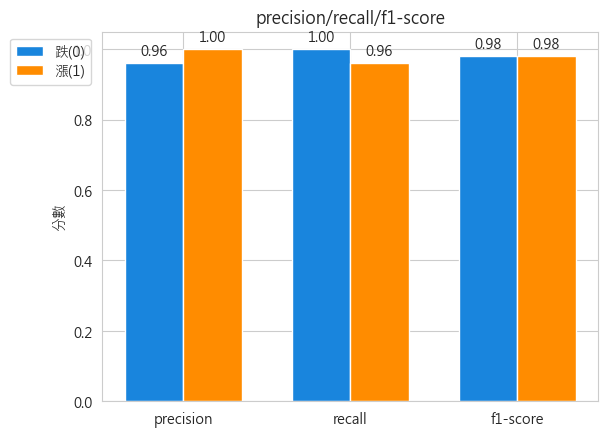

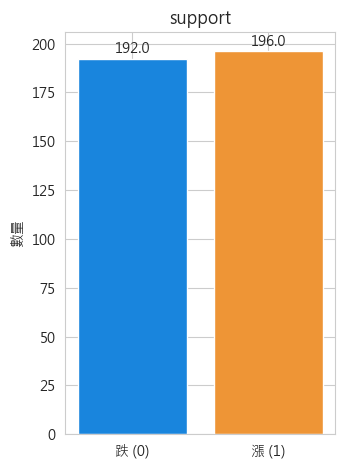

In [18]:
# 📈 邏輯迴歸模型
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

#unique_pred = np.unique(lr_pred)
#print("預測中包含的類別:", unique_pred)

print("📙 邏輯迴歸準確率：", accuracy_score(y_test, lr_pred))
report = classification_report(y_test, lr_pred,output_dict= True)
print(classification_report(y_test, lr_pred))
performanceChart(report)




### 支持向量機(SVM)模型

📒 SVM 準確率： 0.7087628865979382
              precision    recall  f1-score   support

           0       0.87      0.48      0.62       192
           1       0.65      0.93      0.76       196

    accuracy                           0.71       388
   macro avg       0.76      0.71      0.69       388
weighted avg       0.76      0.71      0.69       388



<Figure size 800x400 with 0 Axes>

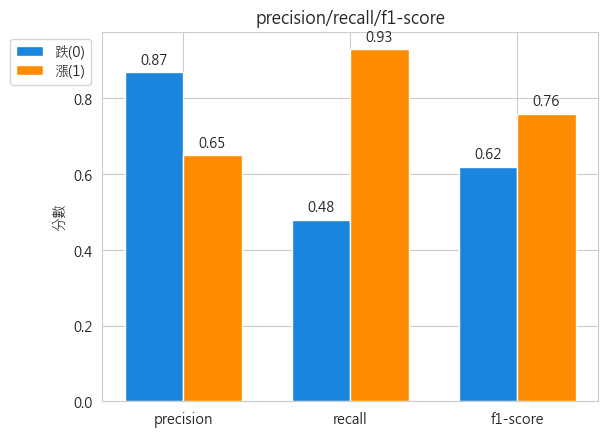

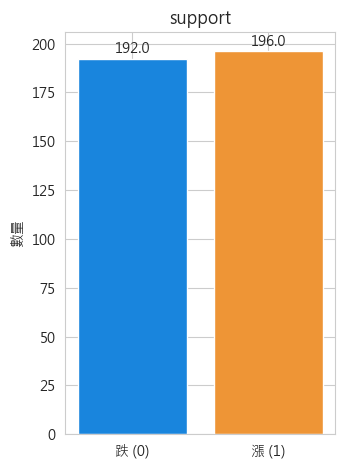

In [19]:
from sklearn.svm import SVC

# 建立並訓練 SVM 模型
svm_model = SVC(kernel='rbf', random_state=0)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("📒 SVM 準確率：", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))
report = classification_report(y_test, svm_pred, output_dict= True)
performanceChart(report)


### 下面的重要性分析不用，僅供參考

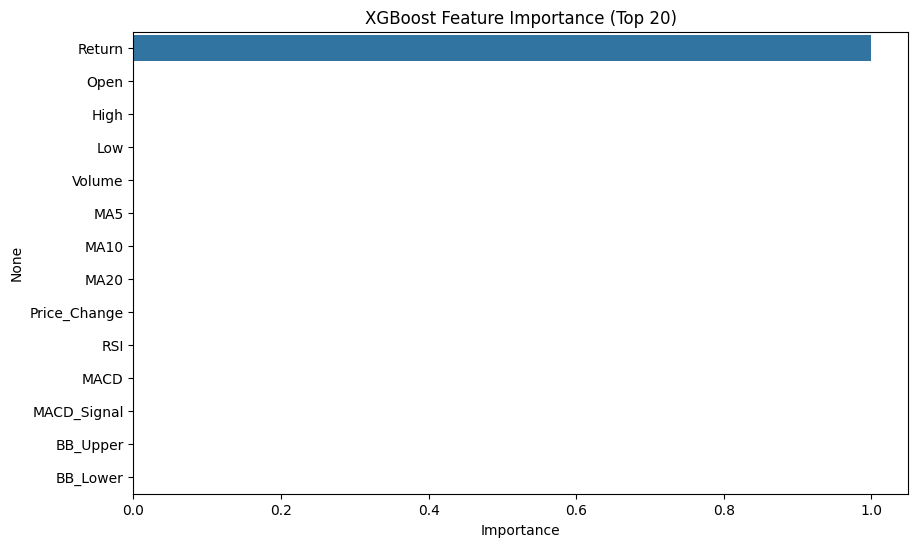

In [17]:
# 📊 XGBoost 特徵重要性分析
xgb_importance = pd.Series(
    xgb_model.feature_importances_, index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importance[:20], y=xgb_importance.index[:20])
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.show()

# import xgboost as xgb
# import matplotlib.pyplot as plt
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
# xgb_model.fit(X_train, y_train)

# # 顯示特徵重要性
# xgb.plot_importance(xgb_model, max_num_features=15, height=0.5)
# plt.title("Feature Importance from XGBoost")
# plt.show()

## 以下僅供參考

如果你關心的是預測「漲」的能力，這個模型的召回率偏低（0.49），可能會錯過很多機會；你可以考慮調整：

類別權重（class_weight）

決策閾值（threshold）

In [13]:
#第一部分：調整類別權重
#SVM 支援 class_weight='balanced' 或自定義權重。

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# 訓練 SVM，平衡類別權重
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)

# 預測
y_pred = svm_model.predict(X_test)

# 評估結果
print("SVM with balanced class weight:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


SVM with balanced class weight:
[[ 64 127]
 [  8 189]]
              precision    recall  f1-score   support

           0       0.89      0.34      0.49       191
           1       0.60      0.96      0.74       197

    accuracy                           0.65       388
   macro avg       0.74      0.65      0.61       388
weighted avg       0.74      0.65      0.61       388



In [14]:
#第二部分：調整預測的決策閾值
#預設是 0.5，我們可以改成 0.4、0.3 等來觀察效果：

import numpy as np

# 預測為類別 1 的機率
y_proba = svm_model.predict_proba(X_test)[:, 1]

# 設定新的閾值（例如 0.4）
threshold = 0.4
y_pred_threshold = (y_proba >= threshold).astype(int)

# 評估新閾值下的結果
print(f"SVM with threshold = {threshold}")
print(confusion_matrix(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))


SVM with threshold = 0.4
[[ 62 129]
 [  6 191]]
              precision    recall  f1-score   support

           0       0.91      0.32      0.48       191
           1       0.60      0.97      0.74       197

    accuracy                           0.65       388
   macro avg       0.75      0.65      0.61       388
weighted avg       0.75      0.65      0.61       388



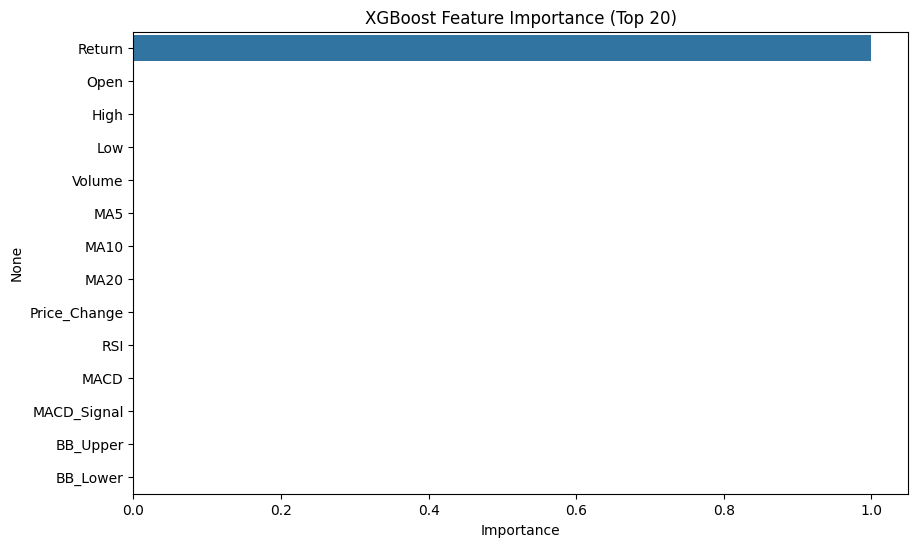

In [29]:
# 📊 特徵重要性分析 (以 XGBoost 為例)
xgb_importance = pd.Series(
    xgb_model.feature_importances_, index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importance[:20], y=xgb_importance.index[:20])
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.show()

d:\Github\Python-2025_04_25\MLOPS\mlops_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:38:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


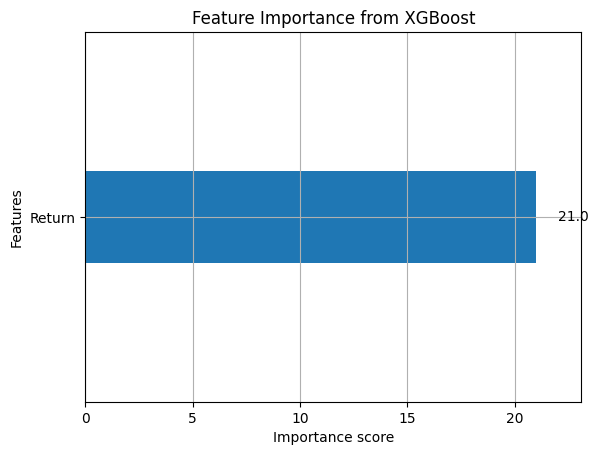

In [12]:
import xgboost as xgb
import matplotlib.pyplot as plt
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# 顯示特徵重要性
xgb.plot_importance(xgb_model, max_num_features=15, height=0.5)
plt.title("Feature Importance from XGBoost")
plt.show()